In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder, FunctionTransformer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
import re
from mpl_toolkits.mplot3d import Axes3D
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [2]:
#Setting random state for reproducibility
rs = min(323001,328854) #since there are two students
np.random.seed(rs)
R = np.random.RandomState(rs)


In [3]:
km = KMeans(random_state=rs) 
df_tot=pd.read_csv('cla4lsp customers.csv',sep='\t')
df_tot

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [4]:
#Sample 2/3 of the dataset 
workdf=df_tot.sample(frac=2/3,random_state=rs)
#check if percentage matches
workdf.shape[0]/df_tot.shape[0]
workdf.columns
workdf=workdf.drop(columns=["ID","Z_CostContact","Z_Revenue"])

In [5]:
#Randomly remove one column
def random_column():
    features_removable=[
    "MntWines", "MntFruits",
    "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds",
    "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"
]
    R = np.random.RandomState(rs)
    random_index=R.randint(0,len(features_removable))
    return features_removable[random_index]
column_to_remove=random_column()
workdf=workdf.drop(columns=column_to_remove)

In [6]:
column_to_remove

'MntWines'

# Dataset analysis

## Attributes distributions

In [7]:
#fig, axis = plt.subplots(11,2,figsize=(15, 8))
#workdf.hist(ax=axis)

In [8]:
#check for missing values
workdf.isna().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 17
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64

In [9]:
workdf = workdf.dropna(subset=['Income'])

In [10]:
# Now all null values have been removed. Let's check if some categorical attribute has been enconded with some string such as 'Unknown'
cat_col_to_check=[]
for column in workdf.columns:
    if pd.api.types.is_object_dtype(workdf[column]):
       cat_col_to_check.append(column)

In [11]:
#Let's check the unique values of these columns
for column in cat_col_to_check:
    print(column,workdf[column].unique())

Education ['Master' 'Graduation' 'Basic' 'PhD' '2n Cycle']
Marital_Status ['Married' 'Together' 'Single' 'Divorced' 'Alone' 'Widow' 'Absurd' 'YOLO']
Dt_Customer ['01-10-2012' '24-03-2013' '04-11-2013' '29-11-2013' '24-10-2013'
 '01-10-2013' '02-01-2013' '07-05-2013' '11-12-2012' '15-02-2014'
 '27-01-2014' '25-01-2014' '03-11-2012' '29-10-2012' '27-12-2013'
 '18-07-2013' '21-07-2013' '04-05-2014' '11-05-2013' '10-03-2013'
 '26-11-2013' '01-03-2014' '04-05-2013' '13-10-2012' '07-07-2013'
 '05-05-2013' '27-08-2012' '15-05-2013' '06-04-2013' '10-12-2013'
 '20-03-2013' '12-10-2013' '30-04-2014' '05-10-2013' '26-03-2013'
 '06-10-2013' '04-01-2014' '06-12-2012' '04-08-2012' '03-08-2012'
 '20-11-2012' '24-05-2014' '18-02-2013' '01-07-2013' '22-06-2013'
 '07-09-2012' '30-05-2013' '29-03-2013' '25-02-2014' '30-10-2013'
 '04-03-2013' '28-09-2012' '22-12-2012' '27-05-2013' '09-12-2013'
 '12-04-2013' '02-10-2013' '03-04-2014' '17-03-2014' '24-08-2012'
 '07-08-2013' '16-01-2013' '20-12-2013' '23-01-

<Axes: xlabel='Education'>

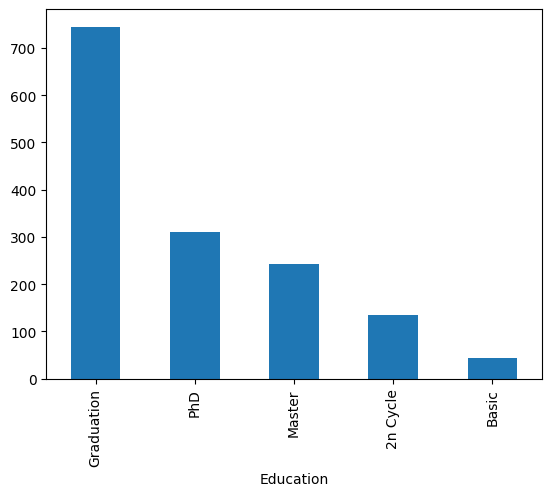

In [12]:

workdf['Education'].value_counts().plot(kind='bar')
#All the categorical attributes have a proper domain. We can proceed with the enconding of the categorical data.

<Axes: xlabel='Age'>

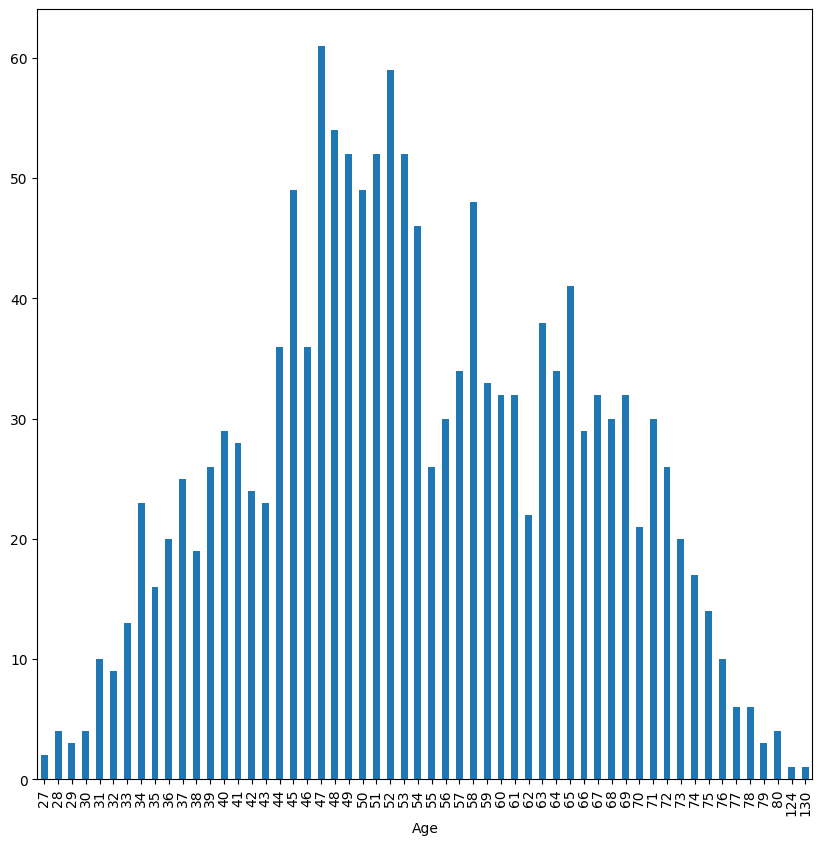

In [13]:
workdf['Age']=2023-workdf['Year_Birth']
workdf['Age'].sort_values().value_counts().sort_index().plot(kind='bar',figsize=(10,10))


# Exercise 2 (Encoding of Categorical Data)

In [14]:
#Ideas:

In [15]:
"""
#copy
enc_marital_status = OneHotEncoder(sparse=False)
#enc_education = OneHotEncoder(sparse=False)
enc_education = LabelEncoder()
enc_marital_status_df = pd.DataFrame(enc_marital_status.fit_transform(workdf[['Marital_Status']]),columns=enc_marital_status.categories_[0])
tmp_df=workdf.copy().reset_index(drop=True)
workdf=tmp_df.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')
#TODO: datetime
#TODO: compute age
"""

"\n#copy\nenc_marital_status = OneHotEncoder(sparse=False)\n#enc_education = OneHotEncoder(sparse=False)\nenc_education = LabelEncoder()\nenc_marital_status_df = pd.DataFrame(enc_marital_status.fit_transform(workdf[['Marital_Status']]),columns=enc_marital_status.categories_[0])\ntmp_df=workdf.copy().reset_index(drop=True)\nworkdf=tmp_df.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')\n#TODO: datetime\n#TODO: compute age\n"

In [16]:
#Date: since date contain some ciclycal data (day and month repeat), we can split date in three variables: day,month,year.
#We can encode day and month with sine/cosine function, as 24:00 is close to 1:00 and December is close to January.
#We can preprocess education with label encoding, since there's a natural order between the education levels.
#We can encode marital_status with one-hot encoding, since the domain of values is limited and there's no order among values.
#We can proceed with the encoding phase:
enc_marital_status = OneHotEncoder(sparse=False)
#usiamo labelenconder perche con meno PCA spieghiamo piu varianza
enc_education = LabelEncoder()
enc_marital_status_df = pd.DataFrame(enc_marital_status.fit_transform(workdf[['Marital_Status']]),columns=enc_marital_status.categories_[0])
tmp_df=workdf.copy().reset_index(drop=True)
workdf=tmp_df.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')
#TODO: datetime
#TODO: compute age
workdf['Education_encoded']=enc_education.fit_transform(workdf['Education'])



/home/omio/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
"""
#Date: since date contain some ciclycal data (day and month repeat), we can split date in three variables: day,month,year.
#We can encode day and month with sine/cosine function, as 24:00 is close to 1:00 and December is close to January.
#We can preprocess education with label encoding, since there's a natural order between the education levels.
#We can encode marital_status with one-hot encoding, since the domain of values is limited and there's no order among values.
#We can proceed with the encoding phase:
enc_marital_status = OneHotEncoder(sparse=False)
enc_education = OneHotEncoder(sparse=False)
#enc_education = LabelEncoder()
enc_marital_status_df = pd.DataFrame(enc_marital_status.fit_transform(workdf[['Marital_Status']]),columns=enc_marital_status.categories_[0])
tmp_df=workdf.copy().reset_index(drop=True)
workdf=tmp_df.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')
#TODO: datetime
#TODO: compute age
"""

"\n#Date: since date contain some ciclycal data (day and month repeat), we can split date in three variables: day,month,year.\n#We can encode day and month with sine/cosine function, as 24:00 is close to 1:00 and December is close to January.\n#We can preprocess education with label encoding, since there's a natural order between the education levels.\n#We can encode marital_status with one-hot encoding, since the domain of values is limited and there's no order among values.\n#We can proceed with the encoding phase:\nenc_marital_status = OneHotEncoder(sparse=False)\nenc_education = OneHotEncoder(sparse=False)\n#enc_education = LabelEncoder()\nenc_marital_status_df = pd.DataFrame(enc_marital_status.fit_transform(workdf[['Marital_Status']]),columns=enc_marital_status.categories_[0])\ntmp_df=workdf.copy().reset_index(drop=True)\nworkdf=tmp_df.merge(enc_marital_status_df,left_index=True, right_index=True,how='left')\n#TODO: datetime\n#TODO: compute age\n"

In [18]:
workdf

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntFruits,MntMeatProducts,...,Age,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO,Education_encoded
0,1949,Master,Married,62845.0,1,1,01-10-2012,3,0,45,...,74,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
1,1960,Graduation,Together,19740.0,0,1,24-03-2013,65,11,3,...,63,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
2,1976,Master,Married,49681.0,0,2,04-11-2013,66,0,26,...,47,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
3,1978,Graduation,Single,38643.0,1,1,29-11-2013,45,2,14,...,45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
4,1971,Graduation,Divorced,29819.0,1,0,24-10-2013,77,1,24,...,52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,1979,Master,Single,16653.0,1,0,18-04-2014,10,7,31,...,44,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
1472,1973,PhD,Married,85844.0,0,0,29-05-2014,62,19,843,...,50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4
1473,1989,2n Cycle,Together,38683.0,1,0,04-10-2012,80,35,69,...,34,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1474,1951,Graduation,Married,30833.0,1,1,16-07-2013,33,0,7,...,72,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2


In [19]:
"""
enc_education_df = pd.DataFrame(enc_education.fit_transform(workdf[['Education']]),columns=enc_education.classes_[0])
workdf.reset_index(drop=True)
workdf=workdf.merge(enc_education_df,left_index=True, right_index=True,how='left')
workdf
"""

"\nenc_education_df = pd.DataFrame(enc_education.fit_transform(workdf[['Education']]),columns=enc_education.classes_[0])\nworkdf.reset_index(drop=True)\nworkdf=workdf.merge(enc_education_df,left_index=True, right_index=True,how='left')\nworkdf\n"

In [20]:
workdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           1476 non-null   int64  
 1   Education            1476 non-null   object 
 2   Marital_Status       1476 non-null   object 
 3   Income               1476 non-null   float64
 4   Kidhome              1476 non-null   int64  
 5   Teenhome             1476 non-null   int64  
 6   Dt_Customer          1476 non-null   object 
 7   Recency              1476 non-null   int64  
 8   MntFruits            1476 non-null   int64  
 9   MntMeatProducts      1476 non-null   int64  
 10  MntFishProducts      1476 non-null   int64  
 11  MntSweetProducts     1476 non-null   int64  
 12  MntGoldProds         1476 non-null   int64  
 13  NumDealsPurchases    1476 non-null   int64  
 14  NumWebPurchases      1476 non-null   int64  
 15  NumCatalogPurchases  1476 non-null   i

# Preprocessing

In [21]:
#preprocessing of income , year of birth, Kidhome,Teenhome, MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth

In [22]:
date_df=pd.to_datetime(workdf['Dt_Customer'],format='%d-%m-%Y').to_frame(name="date")
date_df.iloc[:,0]
date_df['day']=[d.day for d in date_df.iloc[:,0]]
date_df['month']=[d.month for d in date_df.iloc[:,0]]
date_df['year']=[d.year for d in date_df.iloc[:,0]]
date_df['date']=[d.strftime("%d-%m-%Y") for d in date_df['date']]
workdf=workdf.merge(date_df,left_on='Dt_Customer', right_on='date')
#Pre processing
features_excluded=['Education','Marital_Status','Dt_Customer','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response','NumDealsPurchases','Recency','Year_Birth','date']
Xworkdf=workdf.drop(features_excluded,axis=1).copy()
Xworkdf
stdScaler=StandardScaler()
mmScaler=MinMaxScaler()
stdScaler.fit(Xworkdf.values)
mmScaler.fit(Xworkdf.values)
Xworkdf_std=stdScaler.transform(Xworkdf.values)
Xworkdf_mm=mmScaler.transform(Xworkdf.values)

/home/omio/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


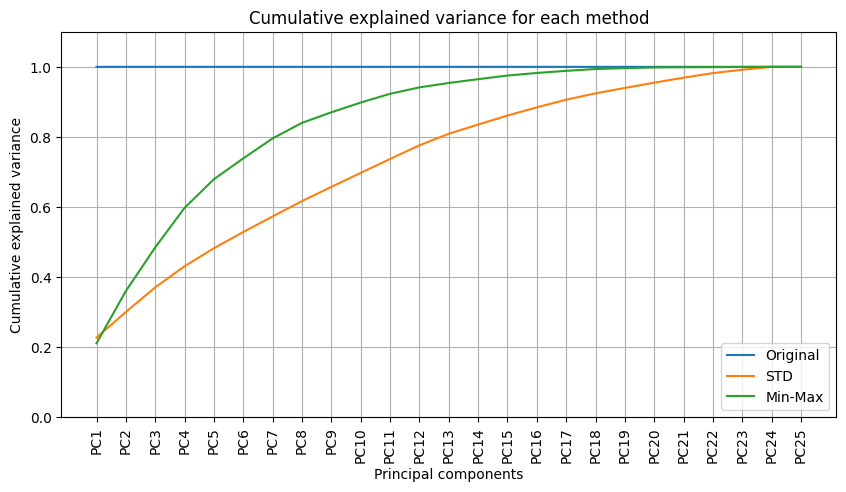

In [23]:
#full pca

pca=PCA()
pca_std=PCA()
pca_mm=PCA()

pca.fit(Xworkdf.values)
pca_std.fit(Xworkdf_std)
pca_mm.fit(Xworkdf_mm)

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_),label='Original')
#plt.title('NOstd')
plt.title('Cumulative explained variance for each method')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca.n_features_)],rotation='vertical')
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
#plt.grid()
#plt.show()

#plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca_std.explained_variance_ratio_),label='STD')
#plt.title('PCA STD')
#plt.ylim([0, 1.1])
#plt.xticks(ticks=np.arange(pca_std.n_features_), 
#           labels=[f'PC{i + 1}' for i in range(pca_std.n_features_)],rotation='vertical')
#plt.xlabel('Principal components')
#plt.ylabel('Cumulative explained variance')
#plt.grid()
#plt.show()

#plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca_mm.explained_variance_ratio_),label='Min-Max')
#plt.title('PCA Min-Max')
#plt.ylim([0, 1.1])
#plt.xticks(ticks=np.arange(pca_mm.n_features_), 
#           labels=[f'PC{i + 1}' for i in range(pca_mm.n_features_)],rotation='vertical')
#plt.xlabel('Principal components')
#plt.ylabel('Cumulative explained variance')
plt.legend()
plt.grid()
plt.show()

In [24]:
#min-max spiega con meno PCA 

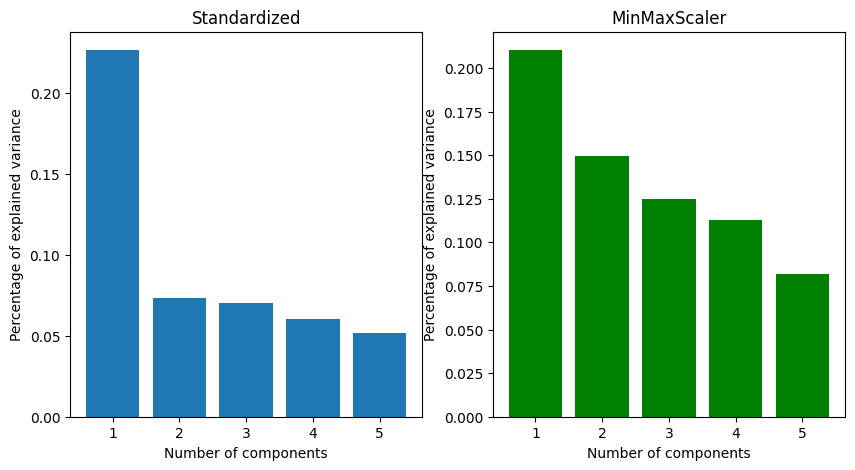

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.arange(1, 6), pca_std.explained_variance_ratio_[:5],
           )
ax[0].set_title('Standardized')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Percentage of explained variance')
ax[1].bar(np.arange(1, 6), pca_mm.explained_variance_ratio_[:5],
           color='green')
ax[1].set_title('MinMaxScaler')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Percentage of explained variance')
plt.show()

In [26]:
target_variance = 0.33
cumulative_variance = 0
num_components = 0

cumulative_variance = np.cumsum(pca_mm.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(num_components)

2


In [27]:
#con min-max ci sono 4 componenti

In [28]:
cumulative_variance = np.cumsum(pca_std.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= target_variance) + 1
print(num_components)

3


In [29]:
#con std vengono 5 componenti
Xworkdf.columns

Index(['Income', 'Kidhome', 'Teenhome', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Age', 'Absurd', 'Alone', 'Divorced', 'Married',
       'Single', 'Together', 'Widow', 'YOLO', 'Education_encoded', 'day',
       'month', 'year'],
      dtype='object')

In [30]:
m_mm=2
m_std=3
pca_mm_m=PCA(n_components=m_mm)
pca_std_m=PCA(n_components=m_std)
pca_mm_m.fit(Xworkdf_mm)
pca_std_m.fit(Xworkdf_std)

Y_mm= pca_mm_m.transform(Xworkdf_mm)
Y_std=pca_std_m.transform(Xworkdf_std)


/home/omio/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


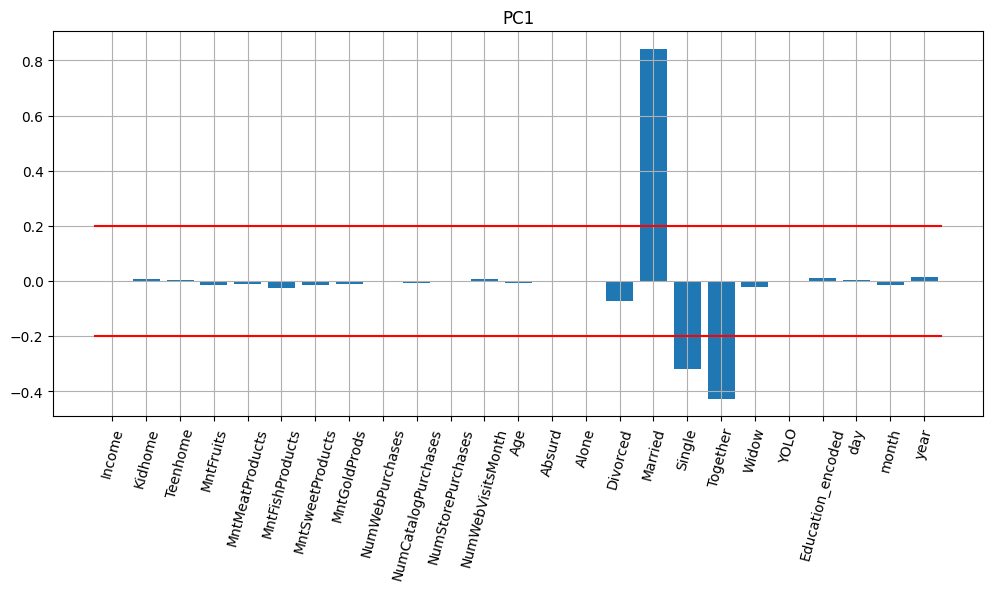


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Married']

HIGH-VALUED NEGATIVE COMPONENTS: ['Single', 'Together']
*********************************************



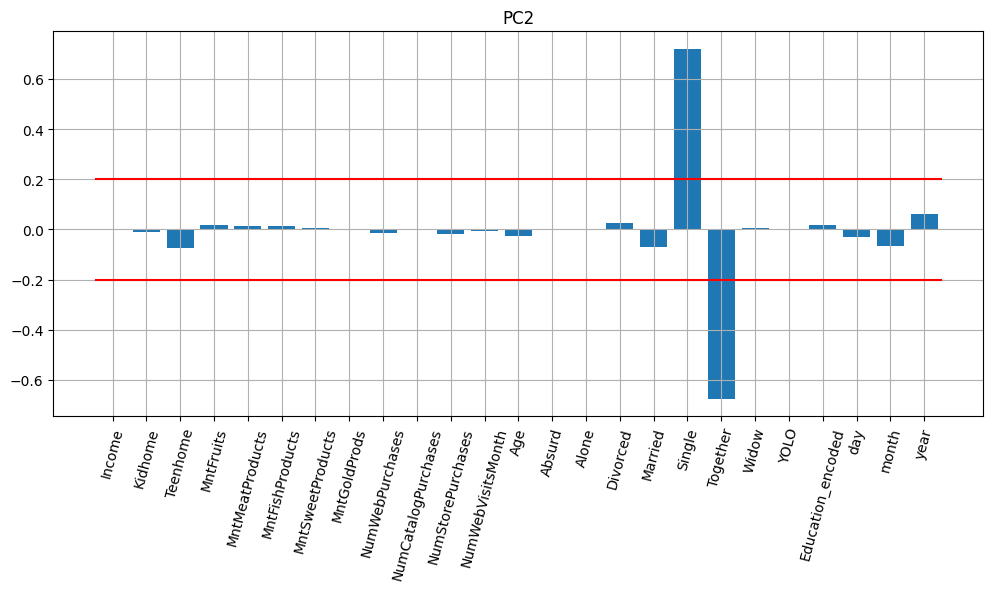


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Together']
*********************************************



In [31]:
features=Xworkdf.columns.to_list()
#Interpretation
# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
eps = np.sqrt(1/pca_mm_m.n_features_)
for ii in range(m_mm):
    # MAKE THE VARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(12, 5))
    plt.title(f"PC{ii + 1}")
    plt.bar(np.arange(pca_mm_m.n_features_),pca_mm_m.components_[ii,:])
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_mm_m.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_mm_m.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_mm_m.n_features_), 
               labels=features, 
               rotation=75)
    plt.grid()
    #plt.tight_layout()
    plt.show()
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii=np.argwhere(pca_mm_m.components_[ii,:]>= eps).flatten()
    ind_great_neg_PCii=np.argwhere(pca_mm_m.components_[ii,:]<= -eps).flatten()
    
    great_pos_PCii=[features[i] for i in ind_great_pos_PCii]
    great_neg_PCii=[features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}') 
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}') 
    print('*********************************************')
    print('')


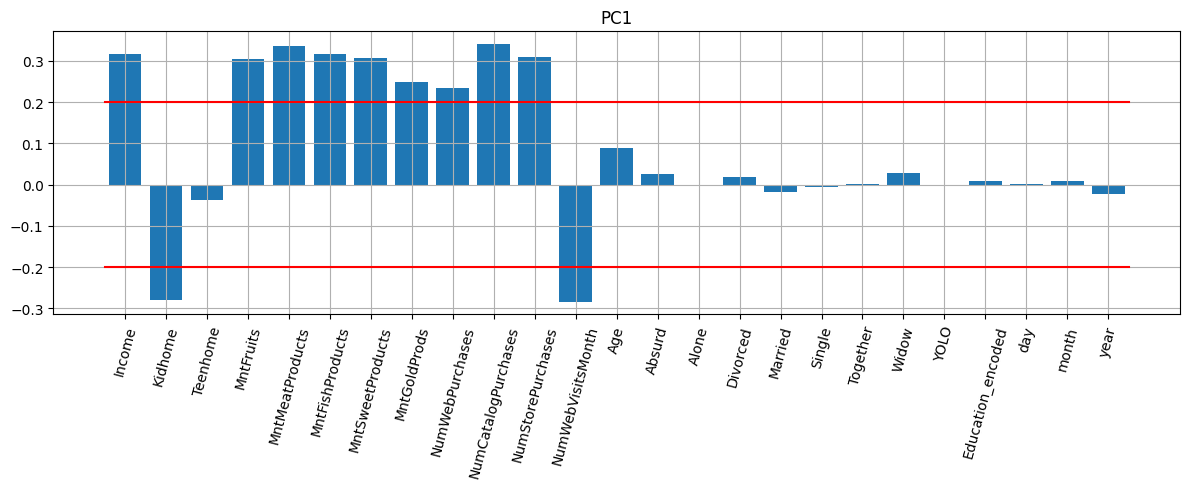


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Income', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome', 'NumWebVisitsMonth']
*********************************************



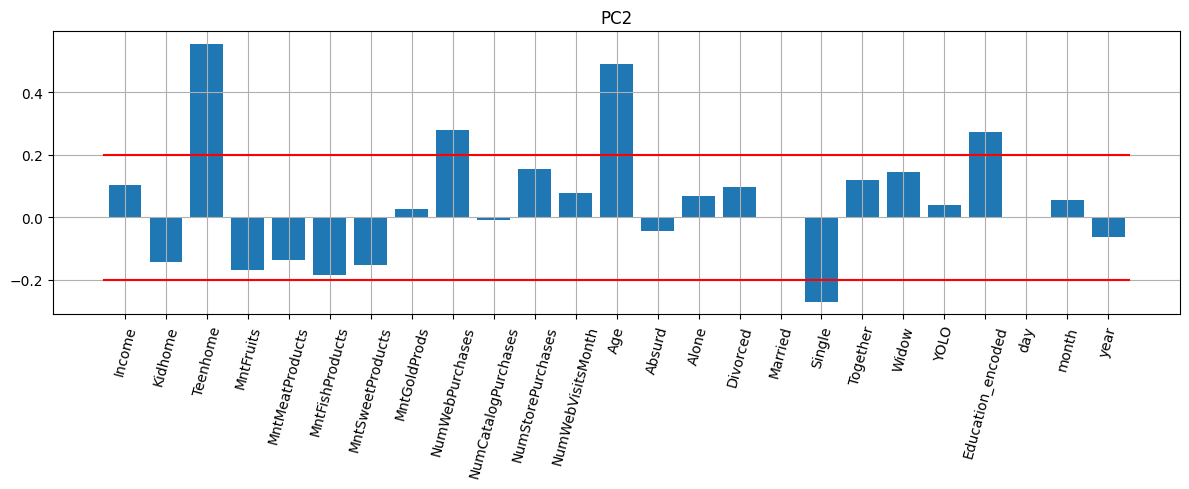


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Teenhome', 'NumWebPurchases', 'Age', 'Education_encoded']

HIGH-VALUED NEGATIVE COMPONENTS: ['Single']
*********************************************



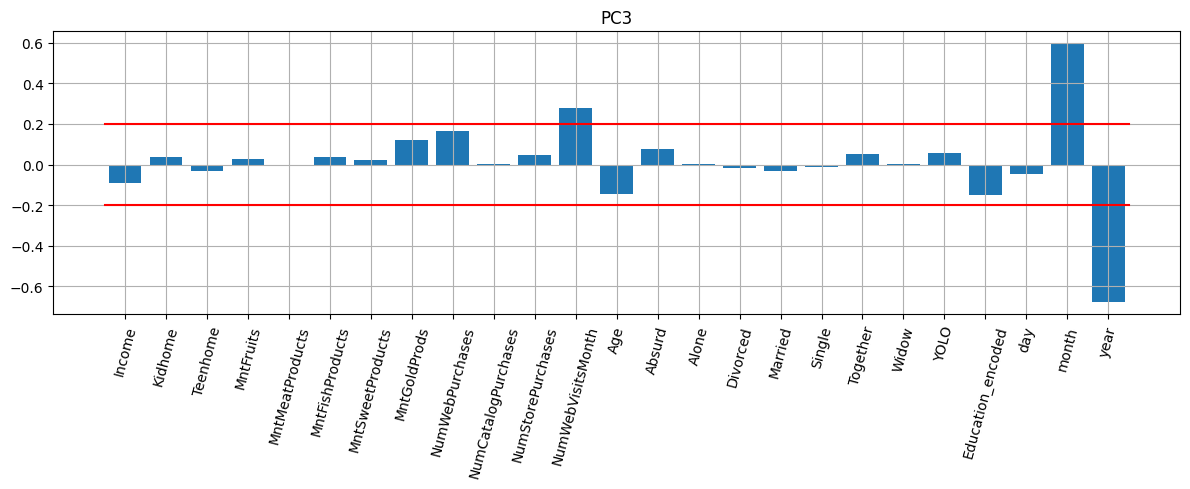


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['NumWebVisitsMonth', 'month']

HIGH-VALUED NEGATIVE COMPONENTS: ['year']
*********************************************



In [32]:
for ii in range(m_std):
    # MAKE THE VARPLOT WITH SKILL TYPE COLORS
    
    plt.figure(figsize=(12,5))
    plt.title(f"PC{ii + 1}")
    plt.bar(np.arange(pca_std_m.n_features_),pca_std_m.components_[ii,:])
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_std_m.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std_m.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_std_m.n_features_), 
               labels=features, 
               rotation=75)
    plt.grid()
    plt.tight_layout()
    plt.show()
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii=np.argwhere(pca_std_m.components_[ii,:]>= eps).flatten()
    ind_great_neg_PCii=np.argwhere(pca_std_m.components_[ii,:]<= -eps).flatten()
    
    great_pos_PCii=[features[i] for i in ind_great_pos_PCii]
    great_neg_PCii=[features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}') 
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}') 
    print('*********************************************')
    print('')

In [33]:
#TODO: guarda distribuzione eta. ci sono minorenni

## Scoregraph

Text(0.5, 1.0, 'Customer segmentation - SCORE GRAPH - Std (PROJ. ON R^2)')

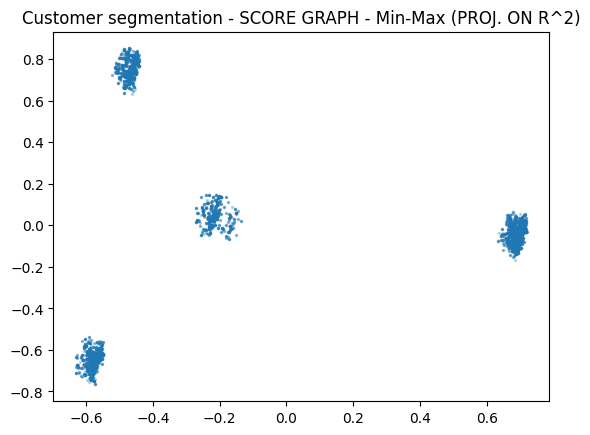

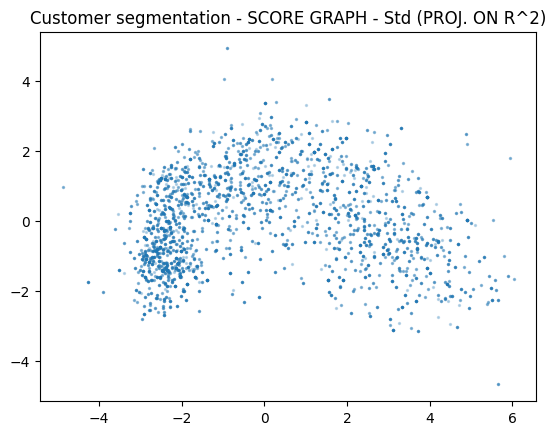

In [34]:
Y_mm = pca_mm.transform(Xworkdf_mm)
Y_std = pca_std.transform(Xworkdf_std)
plt.figure()
plt.scatter(Y_mm[:,0],Y_mm[:,1],s=2,alpha=0.25) 
plt.title('Customer segmentation - SCORE GRAPH - Min-Max (PROJ. ON R^2)')

plt.figure()
plt.scatter(Y_std[:,0],Y_std[:,1],s=2,alpha=0.25) 
plt.title('Customer segmentation - SCORE GRAPH - Std (PROJ. ON R^2)')